In [75]:
import tensorflow as tf
from tensorflow import keras
import os
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


# Load and split data into 80% train, 10% validation and 10% test
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs', 
                                                  split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                  with_info=True,
                                                  as_supervised=True)

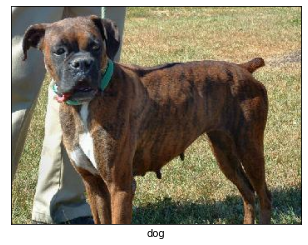

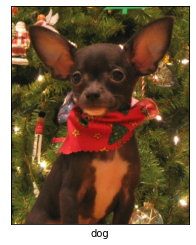

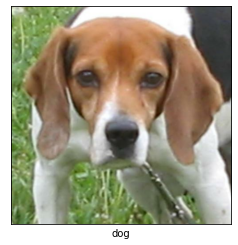

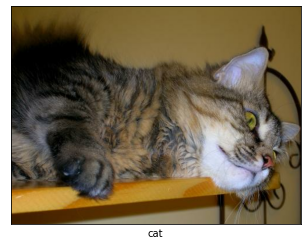

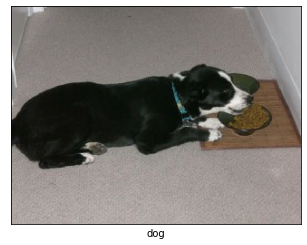

In [72]:
get_label_name = metadata.features['label'].int2str  # creates a function object that we can use to get labels

# Explore images
for image, label in raw_train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.xlabel(get_label_name(label))
    plt.xticks([])
    plt.yticks([])

In [136]:
IMG_SIZE = (160, 160) # All images will be resized to 160x160

def format_example(image, label):
  """
  returns an image that is reshaped to IMG_SIZE
  """
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, IMG_SIZE)
  return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Shuffle and batch images
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)


# Display original and new shape
for img, label in raw_train.take(1):
  print("Original shape:", img.shape)

for img, label in train.take(1):
  print("New shape:", img.shape)

Original shape: (262, 350, 3)
New shape: (160, 160, 3)


In [142]:
# Create base model from pretrained MobileNet V2
IMG_SHAPE = IMG_SIZE + (3, )

base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

# Freeze the base
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [106]:
# Add classifier
global_average_layer = keras.layers.GlobalAveragePooling2D()

# Add prediction layer
prediction_layer = keras.layers.Dense(1)

# Build model
model = keras.models.Sequential([base_model,
                               global_average_layer,
                               prediction_layer])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [143]:
# Train model
base_learning_rate = 0.0001
model.compile(optimizer=keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=keras.losses.BinaryCrossentropy(from_logits=True),
             metrics=['accuracy'])

# Evaluate model before training
initial_epochs = 10
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

history = model.fit(train_batches,
                   epochs=initial_epochs,
                   validation_data=validation_batches)
print("Train accuracy: {}".format(history.history['accuracy']))

20/20 [==============================] - 7s 358ms/step - loss: 0.0431 - accuracy: 0.9828
Epoch 1/10
582/582 [==============================] - 259s 446ms/step - loss: 0.0330 - accuracy: 0.9892 - val_loss: 0.0422 - val_accuracy: 0.9871
Epoch 2/10
582/582 [==============================] - 254s 436ms/step - loss: 0.0327 - accuracy: 0.9889 - val_loss: 0.0421 - val_accuracy: 0.9875
Epoch 3/10
582/582 [==============================] - 260s 447ms/step - loss: 0.0324 - accuracy: 0.9894 - val_loss: 0.0420 - val_accuracy: 0.9875
Epoch 4/10
582/582 [==============================] - 259s 445ms/step - loss: 0.0322 - accuracy: 0.9890 - val_loss: 0.0420 - val_accuracy: 0.9875
Epoch 5/10
582/582 [==============================] - 253s 435ms/step - loss: 0.0321 - accuracy: 0.9893 - val_loss: 0.0421 - val_accuracy: 0.9875
Epoch 6/10
582/582 [==============================] - 241s 414ms/step - loss: 0.0318 - accuracy: 0.9896 - val_loss: 0.0420 - val_accuracy: 0.9880
Epoch 7/10
582/582 [===============

In [109]:
# Save model
model.save("dogs_vs_cats.h5")

In [ ]:
# Learning curve plotting function
def plot_learning_curve(vals):
    train_val, validation_val, train_label, validation_label, title, y_label, x_label, y_lim = vals
    plt.figure()
    plt.plot(train_val, label=train_label)
    plt.plot(validation_val, label=validation_label)
    plt.legend(loc='upper right')
    plt.ylabel(y_label)
    plt.title(title)
    plt.ylim(y_lim)
    plt.xlabel(x_label)
    plt.show()

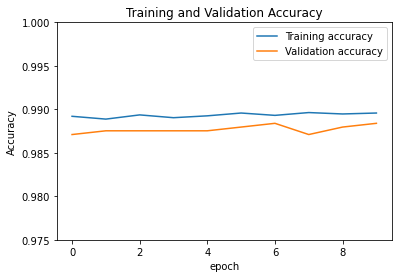

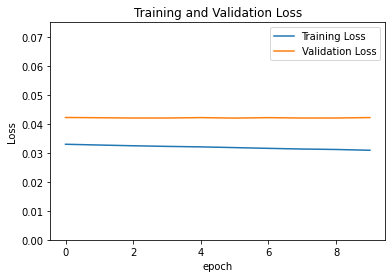

In [235]:
# Plot learning curves before fine-tuning
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

# Compare training and validation accuracy
acc_curve_vals = (acc, val_acc, 'Training accuracy', 'Validation accuracy', 
                    'Training and Validation Accuracy', 'Accuracy', 'epoch', [0.975, 1])
plot_learning_curve(acc_curve_vals)

# Compare training and validation loss
loss_curve_vals = (loss, val_loss, 'Training Loss', 'Validation Loss', 
                    'Training and Validation Loss', 'Loss', 'epoch', [0, 0.075])
plot_learning_curve(loss_curve_vals)

In [184]:
# Fine tuning

# Unfreeze base model layers
base_model.trainable = True
# Number of layers in pre-trained base model
print("Base layers count: {}".format(len(base_model.layers)))

# Fine-tune top 50 layers
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Compile model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=['accuracy'])
print("Fine tuned model summary: {}".format(model.summary()))
print("Fine tuned layers: {}".format(len(model.trainable_variables)))

# Train model
fine_tune_epochs = 3
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Base layers count: 155
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________
Fine tuned model summary: None
Fine tuned layers: 2
Epoch 10/13
582/582 [==============================] - 268s 460ms/step - loss: 0.0301 - accuracy: 0.9898 - val_loss: 0.0423 - val_accuracy: 0.9880
Epoch 11/13
582/582 [==============================] - 263s 452ms/step - loss: 0.0301 - accuracy: 0.9898 - val_loss: 0.0422 - val_accuracy: 0.9880
Epo

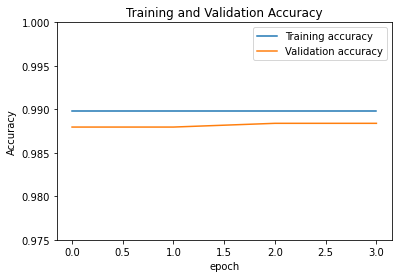

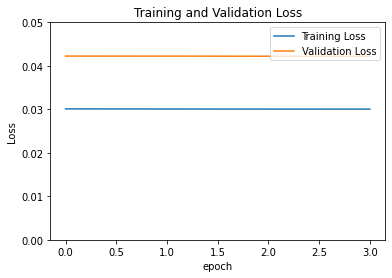

20/20 [==============================] - 7s 351ms/step - loss: 0.0430 - accuracy: 0.9859
Test accuracy : 0.9859374761581421


In [236]:
# Plot learning curves
acc = history_fine.history["accuracy"]
val_acc = history_fine.history["val_accuracy"]

loss = history_fine.history["loss"]
val_loss = history_fine.history["val_loss"]

# Compare training and validation accuracy
acc_curve_vals = (acc, val_acc, 'Training accuracy', 'Validation accuracy', 
                    'Training and Validation Accuracy', 'Accuracy', 'epoch', [0.975, 1])
plot_learning_curve(acc_curve_vals)

# Compare training and validation loss
loss_curve_vals = (loss, val_loss, 'Training Loss', 'Validation Loss', 
                    'Training and Validation Loss', 'Loss', 'epoch', [0, 0.05])
plot_learning_curve(loss_curve_vals)

loss, accuracy = model.evaluate(validation_batches, steps = validation_steps)
print('Test accuracy :', accuracy)